#Functions and code for plotting MEATseq m6A probability stats and read clustering

#This example jup notebook corresponds to the analysis of data presented in Figure 2 and Extended Data Fig 2 of Altemose et. al. 2022 Nature Methods paper.
#Used to analyze 18x601 chromatin DiMeLo-seq data.
#Trial 4 - (CENP-A, H3, Naked DNA) (NT, CA, H3, IgG, Untreated) Top 5k reads only

In [1]:
#outdir - output directory
outfolder = '<outdir>'

In [2]:
#Input Megaladon output - mod_mappings.bam (filter by length to keep file size small)
#Template - 18x601.fa
#Functions:
# parse_bam6_fast - takes in bam file, reads through each read entry and outputs prob score at each A and coverage at each position along the given template. Other outputs include smoothed/sliding window averaged prob score, binary output for m6A call at each A position, number of modified A's and number of A's per read for other statistics, readids.
# extract_Ml_Aa_fast - takes in Mm and Ml from Megaladon output for each read. converts to array with just m6A calls with the correct index (removes mC prob scores)
# m6A_seqmap_prob_fast - takes in positions of A's and T's along template and assigns prob scores from Ml of megaladon output

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kde
%matplotlib inline

import math

import pysam
from Bio import SeqIO

from scipy import sparse

from sklearn import cluster, datasets, mixture, decomposition
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
#inputdir - folder with bam files
#enter name of folder that contains bar1.1, bar1.2,.. etc.
folder_name = '<inputdir>'

In [4]:
Barcode_name = {}

In [5]:
#Example List Barcode titles to be used for graphs here:
Barcode_name[1] = 'CA chr + free PA-Hia5'
Barcode_name[2] = 'CA chr + CA directed PA-Hia5'
Barcode_name[3] = 'CA chr + H3 directed PA-Hia5'
Barcode_name[4] = 'CA chr + IgG directed PA-Hia5'
Barcode_name[5] = 'CA chr + CA Ab. (No PA-Hia5)'
Barcode_name[6] = 'CA chr (untreated)'
Barcode_name[7] = 'H3 chr + free PA-Hia5'
Barcode_name[8] = 'H3 chr + CA directed PA-Hia5'
Barcode_name[9] = 'H3 chr + H3 directed PA-Hia5'
Barcode_name[10] = 'H3 chr + IgG directed PA-Hia5'
Barcode_name[11] = 'H3 chr + H3 Ab. (No PA-Hia5)'
Barcode_name[12] = 'H3 chr (untreated)'
Barcode_name[13] = 'nkd DNA + free PA-Hia5'
Barcode_name[14] = 'nkd DNA + CA directed PA-Hia5'
Barcode_name[15] = 'nkd DNA + H3 directed PA-Hia5'
Barcode_name[16] = 'nkd DNA + IgG directed PA-Hia5'
Barcode_name[17] = 'nkd DNA (untreated)'

In [6]:
Barcode_list = list(range(1,18))
Barcode_list = [1,2,7,8,13,17]

In [7]:
#reading in template into string - template.fa, here - 18x601.fa
array_seq = SeqIO.read("<template.fa>", "fasta")
array_str = str(array_seq.seq)

In [8]:
#identifying indices of A's and T's for assigning mod probs to right positions
#assigning color codes to A's (Green) and T's (Magenta) for easy visualization later in cluster maps 

A_pos = []
T_pos = []
for basepos in range(0,len(array_str)-1):
    if array_str[basepos]=='A':
        A_pos.append(basepos)
    elif array_str[basepos]=='T':
        T_pos.append(basepos)

In [9]:
# extracting m6A prob from Ml, counting A
# input Mm Ml from bam and thr
# output - Mm first value, truncated m6A prob, total A count

In [10]:
def extract_Ml_Aa_fast(Mm, Ml):
         
    first=Mm.split(';')[0]
    if 'C+m' in first:
        A_n=len(Mm.split(';')[1].split(','))-1
        Mm_Aa = Mm.split(';')[1].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa = np.array(Ml[0-A_n:],dtype=int)

    elif 'A+a' in first:
        A_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Aa = Mm.split(';')[0].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa=np.array(Ml[0:A_n],dtype=int)
    
    return Mm_Aa_start, Ml_Aa, A_n

In [13]:
# m6A_seqmap_prob_fast - takes in A or T pos array and readmap start, returns mod prob values assigned to A's along the template
# input arguments - A pos array, T pos array, pos of read along template, if strand=rev, Mm_start, truncated Ml prob values, read length, template length) thresholding done later
# output - m6A prob score along template, coverage along template - for each read

In [14]:
def m6A_seqmap_prob_fast(A_pos_array, T_pos_array, Readmap_start, rev_strand, Mm_start, Ml_Aa, readlength, templatelength = 6302):
    
    if rev_strand == False:
      
    #finding position of first A
        if (Readmap_start < A_pos_array[0]):
                first_A_index = A_pos_array[0]
                
        for i in range(0,len(A_pos_array)-1):
            if ((A_pos_array[i]) <= Readmap_start) and (Readmap_start < (A_pos_array[i+1])):
                if A_pos_array[i] == Readmap_start:
                    first_A_index = i + Mm_start
                else:
                    first_A_index = i+1+Mm_start
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,(len(Ml_Aa)-1)):
            A_index = A_pos_array[first_A_index+j]
            AT_prob_read[A_index] = Ml_Aa[j]
            
    elif rev_strand == True:

        if (Readmap_start < T_pos_array[0]):
                first_T_index = T_pos_array[0]

    #finding position of first T
        for i in range(0,len(T_pos_array)-1):
            if ((T_pos_array[i]) <= Readmap_start) and (Readmap_start < (T_pos_array[i+1])):
                if T_pos_array[i] == Readmap_start:
                    first_T_index = i + Mm_start
                else:
                    first_T_index = i+1+Mm_start
                
                #print(T_pos_array[i], Readmap_start, T_pos_array[first_T_index], T_pos_array[i+1], rev_strand)
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,(len(Ml_Aa)-1)):
            T_index = T_pos_array[first_T_index+j]
            AT_prob_read[T_index] = Ml_Aa[j]
           
    #sequence coverage
    Readmap_end = Readmap_start + readlength - 1
    AT_pos_read = np.zeros(templatelength,dtype=int)
    for k in range(Readmap_start, Readmap_end):
        AT_pos_read[k] = 1
    
    return AT_prob_read, AT_pos_read

In [15]:
def parse_bam6_fast(filename, numreads = 5000, templatelength = 6302):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    A_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:
                    
                    Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                    if rev_strand ==True:
                        Mm_Aa_start = 0
                        Ml_Aa = Ml_Aa[::-1]
                    A_n+=[read_A_n]
                    readids+=[readid]
                    rev_read_list+=[rev_strand]
                
                    AT_prob_read, AT_pos_read = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                
                    AT_prob_list.append(AT_prob_read)
                
                    if rev_strand == False:
                        coverage_Fwd += AT_pos_read
                    elif rev_strand == True:
                        coverage_Rev += AT_pos_read
            
                    count += 1
                    
        except StopIteration:
            reader.close()

            
            AT_prob_arr = np.array(AT_prob_list)
            
            return AT_prob_arr, coverage_Fwd, coverage_Rev, A_n, readids, rev_read_list

In [16]:
def parse_bam6_fast_filt36(filename, numreads = 5000, templatelength = 6302):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    A_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:
                    
                    Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                
                    A_n+=[read_A_n]
                    readids+=[readid]
                    rev_read_list+=[rev_strand]
                
                    AT_prob_read, AT_pos_read = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                
                    AT_prob_list.append(AT_prob_read)
                
                    if rev_strand == False:
                        coverage_Fwd += AT_pos_read
                    elif rev_strand == True:
                        coverage_Rev += AT_pos_read
            
                    count += 1
                    
        except StopIteration:
            reader.close()

            
            AT_prob_arr = np.array(AT_prob_list)
            
            return AT_prob_arr, coverage_Fwd, coverage_Rev, A_n, readids, rev_read_list

BarCode All through for loop

In [18]:
import time

In [19]:
def by_barcode(folder_path, barcodes_list = Barcode_list, numreads = 5000):
    AT_prob_arr_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Fwd_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Rev_bar = {new_list: [] for new_list in barcodes_list} 
    A_n_bar = {new_list: [] for new_list in barcodes_list} 
    readids_bar = {new_list: [] for new_list in barcodes_list} 
    rev_read_list_bar = {new_list: [] for new_list in barcodes_list} 
    filename = {}
    for i in barcodes_list:
        start_time = time.time()
        #Example file name - iterate according to the bam file name as required
        filename[i] = folder_path + 'bar' + str(i) + '.1/mod_mappings_3.6kb.bam'
        AT_prob_arr_bar[i], coverage_Fwd_bar[i], coverage_Rev_bar[i], A_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_fast(filename[i], numreads)
        
        print('Finished barcode ', i, 'in ', "--- %s seconds ---" % (time.time() - start_time))
        
    return AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar

In [20]:
AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, Barcode_list, 5000)

Finished barcode  1 in  --- 2.7884557247161865 seconds ---
Finished barcode  2 in  --- 5.108734607696533 seconds ---
Finished barcode  7 in  --- 3.99444842338562 seconds ---
Finished barcode  8 in  --- 5.856286287307739 seconds ---
Finished barcode  13 in  --- 6.210620880126953 seconds ---
Finished barcode  17 in  --- 4.689466238021851 seconds ---


In [21]:
#COVERAGE
def coverage(barcodes_list, coverage_Fwd_bar, coverage_Rev_bar, templatelength = 6302, label_name = Barcode_name):
    coverage_bar = {new_list: [] for new_list in barcodes_list}
    x = np.arange(templatelength)    
    for i in barcodes_list:
        coverage_bar[i] = coverage_Fwd_bar[i] + coverage_Rev_bar[i]
        plt.plot(x, np.array(coverage_bar[i]), label = label_name[i])
    plt.xlabel('bp of ASP 696 18x601', fontsize = 14)
    plt.ylabel('# of read', fontsize = 14)
    plt.title('coverage', fontsize=14)
    plt.legend(fontsize = 14)
    plt.show()
    return coverage_bar

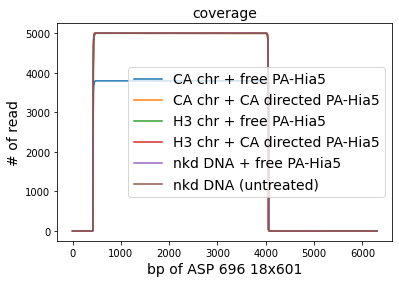

In [22]:
coverage_bar = coverage(Barcode_list, coverage_Fwd_bar, coverage_Rev_bar)

In [59]:
#making a binary mod prob > thr array using numpy
def binary_mod(barcodes_list, AT_prob_arr_bar, coverage_bar, AT_mod_arr_bar={}, thr=75):
    thr256 = thr/100*256
    try: AT_mod_arr_bar
    except NameError: 
        AT_mod_arr_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        AT_mod_arr_bar[i] = np.ndarray.astype(AT_prob_arr_bar[i] >= thr256, int)
    return AT_mod_arr_bar

In [60]:
AT_mod_arr_bar = binary_mod(Barcode_list, AT_prob_arr_bar, coverage_bar)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


In [61]:
#making a binary mod prob > thr array using numpy
def frac_m6A(barcodes_list, AT_mod_arr_bar, A_n_bar, m6A_over_A_bar = {}):
    N_mod_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        N_mod_bar[i] = AT_mod_arr_bar[i].sum(axis = 1)
        m6A_over_A_bar[i] = np.ndarray.astype(N_mod_bar[i]/A_n_bar[i], float)
    return m6A_over_A_bar

In [62]:
m6A_over_A_bar = frac_m6A(Barcode_list, AT_mod_arr_bar, A_n_bar)

In [63]:
colorpal = ['#BB4420','#FFBC0A','#053C5E','#A9E5BB','#610345','#2D1E2F','#559CAD','#5E747F']

In [64]:
def plot_m6A_over_A_combined(barcodes_list, m6A_over_A_bar, ylimit=(0,22), xlimit = (0,1), num_bins = 100, label_name = Barcode_name, colorpal = ['#FFBC0A','#053C5E','#559CAD','#610345','#A9E5BB','#2D1E2F','#BB4420','#5E747F']):

    def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return
    fig, ax1 = plt.subplots(figsize = (3.6,2.4))
    barcodes_list_str = ''
    a = 0
    alp = [0.6,0.6,0.4,0.4]
    for i in barcodes_list:
        barcodes_list_str += '_' + str(i)
        ax1.hist(m6A_over_A_bar[i], bins = 75, density = True, alpha = alp[a], label = label_name[i], color = colorpal[a], histtype = 'barstacked')
        ax1.set_ylabel('frequency', fontsize = 14)
        ax1.set_ylim(0,20)
        ax1.set_xlabel('mA/A per read', fontsize = 14)
        ax = ax1.twinx()
        ax.hist(m6A_over_A_bar[i], bins = 1000, density = True, alpha = 1, label = label_name[i], cumulative=True, histtype='step', rwidth = 1, color = colorpal[a])
        ax.set_ylabel('fraction of reads', fontsize = 14)
        ax.set_ylim(0,1)
        a += 1
        legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1-a/6), loc='upper left')
        
    
    #plt.xlabel('mA/A (per read)', fontsize = 14)
    #plt.legend(fontsize=14)
    #legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1), loc='upper left')
    #plt.ylim(ylimit)
    plt.xlim(xlimit)
    plt.show()
    #if cumul == True:
    fig.savefig(outfolder+'plot_m6A_over_A_Cumulative_hist_combined_75_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'plot_m6A_overA_Cumulative_hist_combined_legend_75_'+ barcodes_list_str + '.png'))
    #else:
    #    fig.savefig(outfolder+'plot_m6A_over_A_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    #    export_legend(legend, str(outfolder + 'plot_m6A_overA_legend_'+ barcodes_list_str + '.png'))
    

    
    return

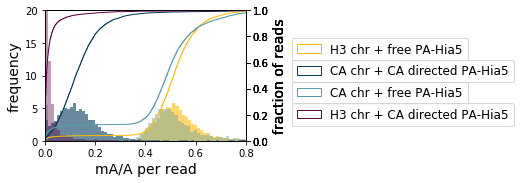

In [65]:
ax = plot_m6A_over_A_combined([7,2,1,8],m6A_over_A_bar, ylimit = [0,100], xlimit = [0,0.8], num_bins=1000)

In [178]:
def binary_mod_sum_norm(barcodes_list, AT_mod_arr_bar, AT_mod_sum_norm_bar={}):
    for i in barcodes_list:
        AT_mod_sum_norm_bar[i] = np.ndarray.astype((AT_mod_arr_bar[i].sum(axis=0))/(coverage_bar[i]), float)
    return AT_mod_sum_norm_bar

In [179]:
AT_mod_sum_norm_bar = binary_mod_sum_norm([1,2,7,8], AT_mod_arr_bar)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
def plot_mod_sum_norm(barcodes_list, AT_mod_sum_norm_bar, ylimit = (0,1), xlimit = (0,6302), label_name = Barcode_name):
    x = np.arange(6302)
    fig = plt.figure(figsize=(8,5))
    barcodes_list_str = ''
    for i in barcodes_list:
        barcodes_list_str += '_' + str(i)
        plt.plot(x, AT_mod_sum_norm_bar[i], alpha=0.7, label = label_name[i])
    plt.xlabel('bp of ASP 696 18x601', fontsize=16)
    plt.ylabel('fraction of reads', fontsize=16)
    plt.title('Average Probability of m6A', fontsize=16)
    plt.ylim(ylimit)
    plt.xlim(xlimit)
    plt.legend(fontsize = 16)
    for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='black', linestyle='--')
    #fig.savefig(outfolder+'plot_mod_sum_norm'+barcodes_list_str, dpi = 300)
    plt.show()

In [181]:
def plot_mod_sum_norm_ind(barcodes_list, AT_mod_sum_norm_bar, ylimit = (0,1), xlimit = (0,6302), label_name = Barcode_name):
    x = np.arange(6302)
    fig, axs = plt.subplots(1, len(barcodes_list), figsize=(40/3*len(barcodes_list), 10))
    count = 0
    for i in barcodes_list:
        count += 1
        axs[count-1].plot(x, AT_mod_sum_norm_bar[i], alpha=1, color = "#053C5E")
        axs[count-1].set_xlabel('bp of ASP 696 18x601', fontsize=20)
        axs[count-1].set_ylabel('fraction of reads', fontsize=20)
        axs[count-1].set_title(label_name[i], fontsize=22)
        axs[count-1].set_ylim(ylimit)
        axs[count-1].set_xlim(xlimit)
        axs[count-1].xaxis.set_tick_params(labelsize=18)
        axs[count-1].yaxis.set_tick_params(labelsize=18)
        for mon in range(0,18):
            axs[count-1].axvline(549+200*mon, 0,1, color='grey', linestyle='--')

        fig.show()

In [182]:
def plot_mod_sum_norm_squished(barcodes_list, AT_mod_sum_norm_bar, ylimit = (0,1), xlimit = (0,6302), label_name = Barcode_name, colorpal = ['#053C5E','#559CAD','#FFBC0A','#610345','#A9E5BB','#2D1E2F','#BB4420','#5E747F']):
    x = np.arange(6302)
    barcodes_list_str = ''
    a = 0
    fig = plt.figure(figsize=(4,0.5))
        
    for i in barcodes_list:
        barcodes_list_str += str(i) + '_'
        plt.plot(x, AT_mod_sum_norm_bar[i], alpha=1, color = colorpal[a])
        #plt.xlabel('bp of ASP 696 18x601', fontsize=16)
        plt.ylabel('m6A/read', fontsize=16)
        #plt.title(label_name[i], fontsize=18, loc='left')
        plt.ylim(ylimit)
        plt.xlim(xlimit)
        for mon in range(0,18):
            plt.axvline(549+200*mon, 0,0.75, color='red', linestyle='--', alpha = 0.5)
        a+=1
    plt.show()    
    fig.savefig(outfolder+'plot_mod_sum_norm_squished_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
       
    
    return

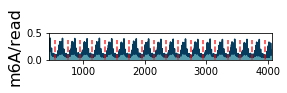

In [185]:
plot_mod_sum_norm_squished([1,2], AT_mod_sum_norm_bar, (0,0.5),(445,4074))

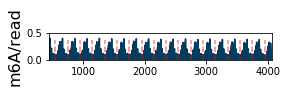

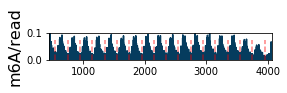

In [187]:
plot_mod_sum_norm_squished([1], AT_mod_sum_norm_bar, (0,0.5),(445,4074))
plot_mod_sum_norm_squished([2], AT_mod_sum_norm_bar, (0,0.1),(445,4074))

In [24]:
AT_prob_arr_bar_filt50 = {}
for i in Barcode_list:
    AT_prob_arr_bar_filt50[i] = AT_prob_arr_bar[i]
    AT_prob_arr_bar_filt50[i][AT_prob_arr_bar[i]<=130] = 0

In [25]:
## Bin each read of 6302 bp into 50 bp bins overlapping bins, 1 bp stepsize, Binning to identify at least 1 mA probability
binsize = 50
stepsize = 1
templatelength = 6302

In [26]:
colorpal = ['#BB4420','#053C5E','#610345','#2D1E2F','#A9E5BB','#FFBC0A','#559CAD', '#5E747F', '#FF0000','#00FF00', '#FFFF00']

In [27]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize , Binning by averaging probability
AT_prob_arr_bin_mA = {}
for i in Barcode_list:
    AT_prob_arr_bin_mA[i] = np.zeros((np.shape(AT_prob_arr_bar_filt50[i][0:3000])[0],int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][0:3000,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


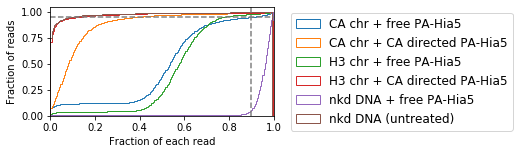

In [29]:
#Plotting what fraction of each read is methylated on average across the library

plt.figure(figsize=(4,2))
for i in Barcode_list:
    plt.hist(np.mean(AT_prob_arr_bin_mA[i][:,445:4074]>0.6, axis = 1), label = Barcode_name[i], bins=200, density = True, cumulative=True, histtype='step')
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0,1)
    plt.xlabel('Fraction of each read')
    plt.ylabel('Fraction of reads')
plt.axhline(0.95,0,1, color = 'grey', linestyle = '--')
plt.axvline(0.90,0,1, color = 'grey', linestyle = '--')
plt.show()

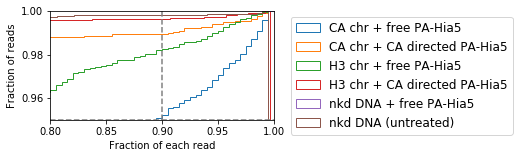

In [32]:
#Plotting what fraction of each read is methylated on average across the library

plt.figure(figsize=(4,2))
for i in Barcode_list:
    plt.hist(np.mean(AT_prob_arr_bin_mA[i][:,445:4074]>0.6, axis = 1), label = Barcode_name[i], bins=200, density = True, cumulative=True, histtype='step')
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0.8,1)
    plt.ylim(0.95,1)
    plt.xlabel('Fraction of each read')
    plt.ylabel('Fraction of reads')
plt.axhline(0.95,0,1, color = 'grey', linestyle = '--')
plt.axvline(0.90,0,1, color = 'grey', linestyle = '--')
plt.show()

In [28]:
dyads = np.asarray([549+200*mon for mon in range(0,18)])
win_size = 200
thresh_numbins = 10
thresh_numbins_frac = thresh_numbins/win_size
AT_nuc_calls = {}
AT_nuc_calls_mod = {}
for i in Barcode_list:
    AT_nuc_calls[i] = np.asarray([np.mean(AT_prob_arr_bin_mA[i][:,max(dyad-win_size,474):min(dyad+win_size,4074)]>0.6, axis = 1) for dyad in dyads]).transpose()
    AT_nuc_calls[i] = (AT_nuc_calls[i] >= thresh_numbins_frac) * (AT_nuc_calls[i] < 0.6)

In [37]:
import scipy

In [75]:
nuc_count_dict = {}
for i in [1,2,7,8,17]:
    nuc_count_dict[i] = np.asarray(np.sum(AT_nuc_calls[i],1))

In [78]:
nuc_count_df = pd.DataFrame.from_dict(nuc_count_dict)

In [81]:
[Barcode_name[i] for i in [1,2,7,8,17]]

['CA chr + free PA-Hia5',
 'CA chr + CA directed PA-Hia5',
 'H3 chr + free PA-Hia5',
 'H3 chr + CA directed PA-Hia5',
 'nkd DNA (untreated)']

In [84]:
nuc_count_df = nuc_count_df.rename(columns={i:Barcode_name[i] for i in [1,2,7,8,17]})

In [90]:
nuc_count_df.to_csv(outfolder + 'nuc_count.csv', index = False)

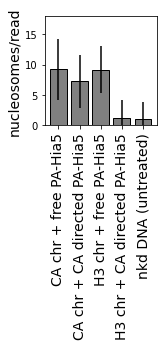

In [30]:
plt.figure(figsize = (2,2))
#for i in [1,2,7,8,17]:
plt.bar(np.arange(0,5),[np.mean(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,17]], tick_label = [Barcode_name[i] for i in [1,2,7,8,17]], edgecolor = 'black', color = 'grey')
plt.xticks(rotation = 90, fontsize = 14)
plt.errorbar(np.arange(0,5),[np.mean(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,17]],yerr = [np.std(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,17]], fmt = 'none', color = 'black')
plt.ylabel('nucleosomes/read', fontsize = 14)
plt.ylim(0,18)
#plt.savefig(outfolder + 'nuc_count_per_read_'+ str(win_size) + 'win_' +str(int(thresh_numbins_frac*100)) + 'fracbin.png', dpi = 300, bbox_to_anchor = 'tight')
plt.show()

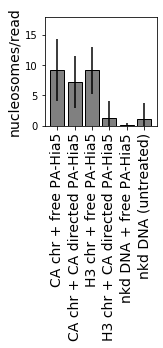

In [291]:
plt.figure(figsize = (2,2))
#for i in [1,2,7,8,17]:
plt.bar(np.arange(0,6),[np.mean(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,13,17]], tick_label = [Barcode_name[i] for i in [1,2,7,8,13,17]], edgecolor = 'black', color = 'grey')
plt.xticks(rotation = 90, fontsize = 14)
plt.errorbar(np.arange(0,6),[np.mean(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,13,17]],yerr = [np.std(np.sum(AT_nuc_calls[i],1)) for i in [1,2,7,8,13,17]], fmt = 'none', color = 'black')
plt.ylabel('nucleosomes/read', fontsize = 14)
plt.ylim(0,18)
#plt.savefig(outfolder + 'nuc_count_per_read_'+ str(win_size) + 'win_' +str(int(thresh_numbins_frac*100)) + 'fracbin.png', dpi = 300, bbox_to_anchor = 'tight')
plt.show()

In [76]:
#Pairwise comparisons and p-values

ilist = []
for i in [1,2,7,8,17]:
    for j in [1,2,7,8,17]:
        if i != j:
            if j not in ilist:
                pval = scipy.stats.ttest_ind(nuc_count_dict[i],nuc_count_dict[j])[1]
                if pval > 0.5:
                    sig = 'ns'
                elif pval <= 0.5 and pval > 0.01:
                    sig = '*'
                elif pval <= 0.1 and pval > 0.001:
                    sig = '**'
                elif pval <= 0.001:
                    sig = '***'
                print(i, '\t\t', j, '\t\t', np.round(pval,3), '\t\t', sig)
            ilist.append(i)

1 		 2 		 0.0 		 ***
1 		 7 		 0.558 		 ns
1 		 8 		 0.0 		 ***
1 		 17 		 0.0 		 ***
2 		 7 		 0.0 		 ***
2 		 8 		 0.0 		 ***
2 		 17 		 0.0 		 ***
7 		 8 		 0.0 		 ***
7 		 17 		 0.0 		 ***
8 		 17 		 0.02 		 *


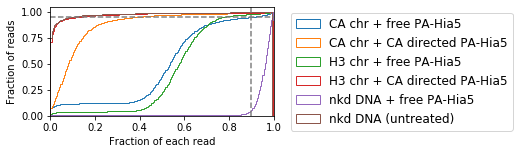

In [134]:
plt.figure(figsize=(4,2))
for i in Barcode_list:
    plt.hist(np.mean(AT_prob_arr_bin_mA[i][:,445:4074]>0.6, axis = 1), label = Barcode_name[i], bins=200, density = True, cumulative=True, histtype='step')
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0,1)
    plt.xlabel('Fraction of each read')
    plt.ylabel('Fraction of reads')
plt.axhline(0.95,0,1, color = 'grey', linestyle = '--')
plt.axvline(0.90,0,1, color = 'grey', linestyle = '--')
plt.show()

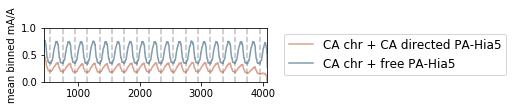

In [255]:
a = 0
plt.figure(figsize = (4,1))
for i in [2,1]:
    plt.plot(np.arange(0,templatelength,stepsize),np.nanmean(AT_prob_arr_bin_mA[i], axis = 0), alpha = 0.5, color = colorpal[a], label = Barcode_name[i])
    a+=1
for mon in range(0,18):
    plt.axvline(549+200*mon, 0,1, color='grey', linestyle='--', alpha = 0.5)
plt.ylabel('mean binned mA/A')
plt.xlim(445,4074)
plt.ylim(0,1)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [26]:
lefttrim_only = 445
righttrim_only = 4074

In [27]:
AT_prob_arr_bin_mA_trimonly = {}
for i in Barcode_list:
    AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

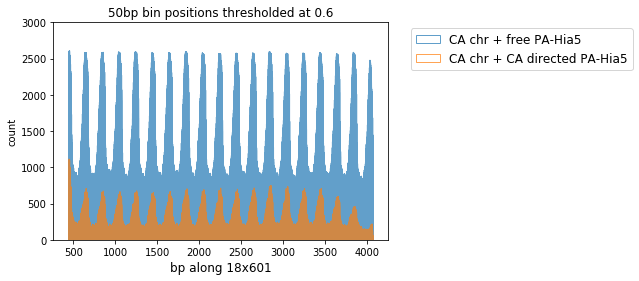

In [262]:
thre = 0.6
for i in [1,2]:
    plt.hist(np.nonzero(AT_prob_arr_bin_mA_trimonly[i]>thre)[1]*stepsize+lefttrim_only, bins = int(templatelength/stepsize), label= Barcode_name[i], density = False, alpha = 0.7, histtype='step')
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('50bp bin positions thresholded at ' + str(thre))
    plt.xlabel('bp along 18x601', fontsize=12)
    plt.ylabel('count')
    plt.ylim(0,3000)
plt.show()

# Clustermaps

In [28]:
m6ABlue = sns.light_palette("#053C5E", 1000)
m6ABlue[0] = (1,1,1)

In [263]:
d_rows={}
row_linkage_mod = {}

In [264]:
for i in [1,2]:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA[i]>0.8),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)

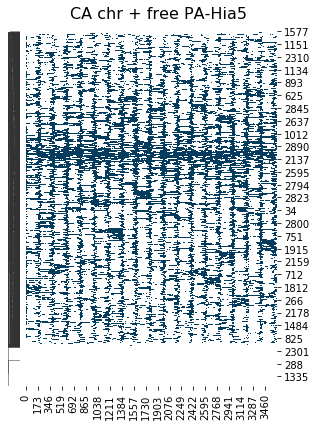

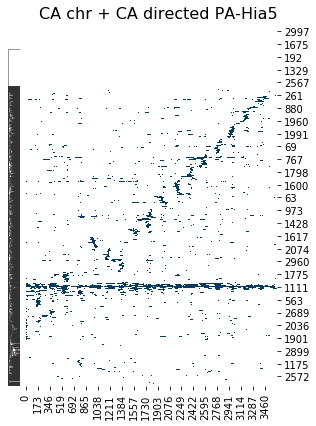

In [284]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.8)[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

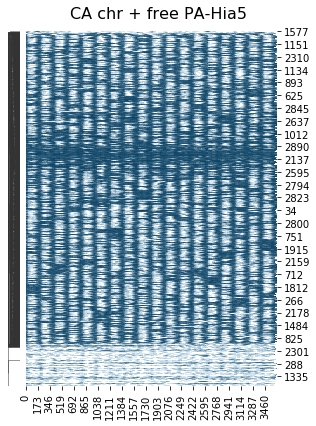

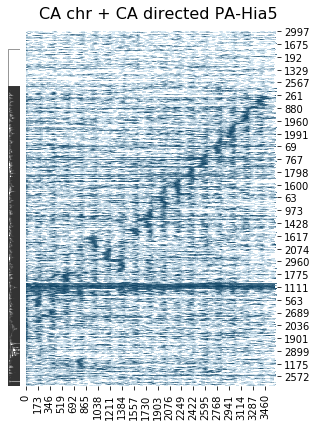

In [283]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i])[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

In [344]:
d_rows2={}
row_linkage_mod2 = {}

In [345]:
for i in [1,2]:

    d_rows2[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA[i]>0.6),metric='jaccard')

    row_linkage_mod2[i] = hierarchy.linkage(ssd.squareform(d_rows2[i]), method='average',optimal_ordering=True)

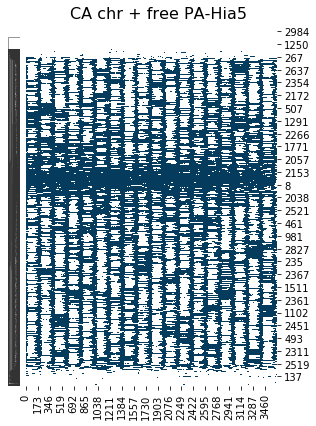

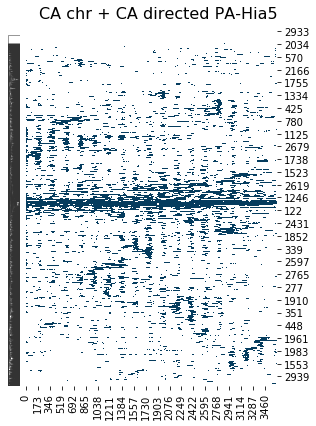

In [348]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.6)[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'clustered_06'+ str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

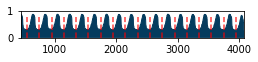

In [32]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[1]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,1)
plt.xlim(445,4074)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_01.png', dpi=300)
plt.show()


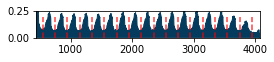

In [33]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[2]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,0.25)
plt.xlim(445,4074)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_02.png', dpi=300)
plt.show()


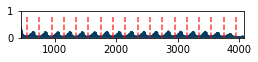

In [34]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[2]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,1)
plt.xlim(445,4074)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_02_fullY.png', dpi=300)
plt.show()


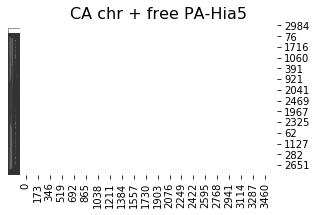

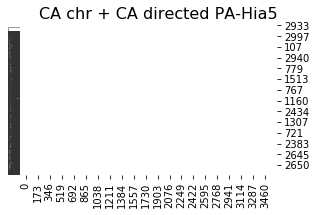

In [347]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.6)[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'clustered_06'+ str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

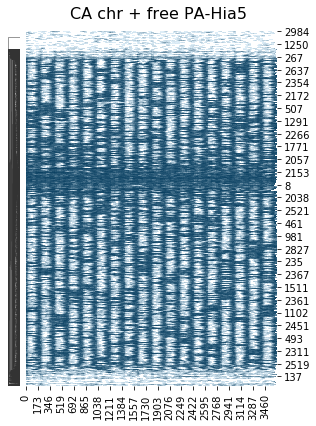

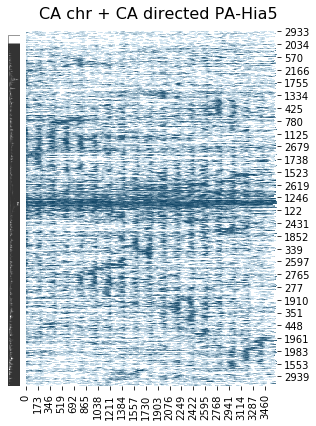

In [280]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i])[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

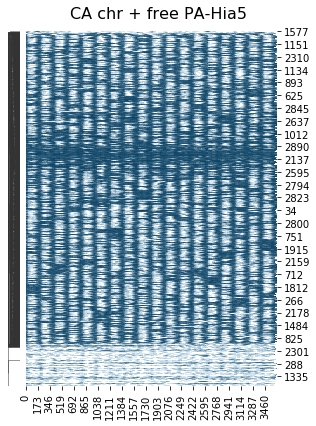

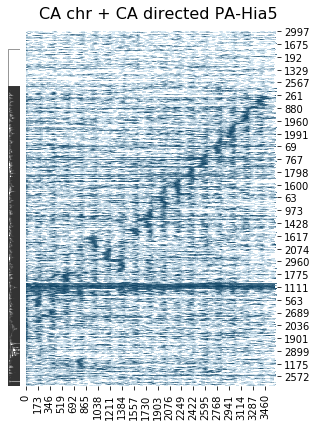

In [281]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i])[:,445:4074], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

### 4x zoomed in

In [296]:
d_rows2_4x={}
row_linkage_mod2_4x = {}

In [300]:
for i in [1,2]:

    d_rows2_4x[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA[i]>0.6)[:,1801:2700],metric='jaccard')

    row_linkage_mod2_4x[i] = hierarchy.linkage(ssd.squareform(d_rows2_4x[i]), method='average',optimal_ordering=True)

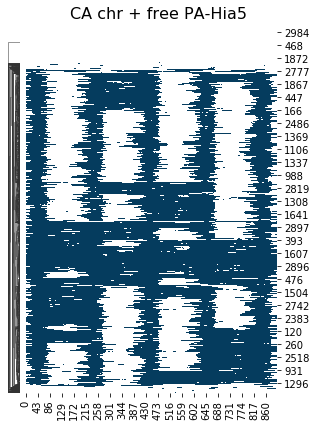

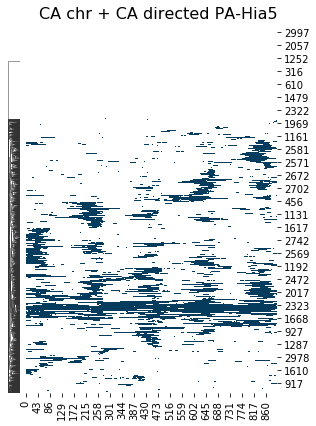

In [389]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.6)[:,1801:2700], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2_4x[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'clustered_06'+ str(i) + '_4x.png', dpi=300)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

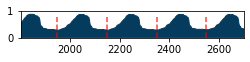

In [35]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[1]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,1)
plt.xlim(1801,2700)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_01_4x.png', dpi=300)
plt.show()


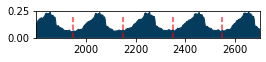

In [38]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[2]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,0.25)
plt.xlim(1801,2700)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_02_4x.png', dpi=300)
plt.show()



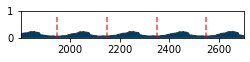

In [39]:
fig = plt.figure(figsize=(4,0.5))
plt.fill_between(np.arange(0,6302),np.nanmean((AT_prob_arr_bin_mA[2]>0.6)[0:3000], axis = 0), alpha = 1, color = "#053C5E")
plt.ylim(0,1)
plt.xlim(1801,2700)
for mon in range(0,18):
        plt.axvline(549+200*mon, 0,0.75, color='red', alpha = 0.75, linestyle='--')
plt.savefig(outfolder + 'bin_aggregate_06_02_4x_fullY.png', dpi=300)
plt.show()


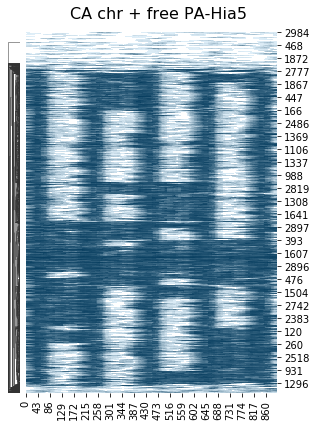

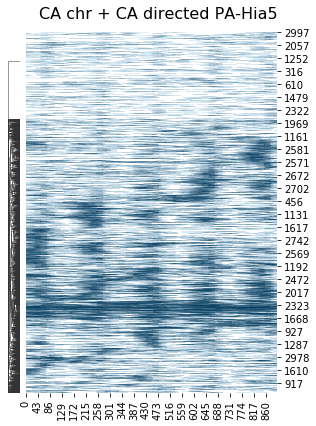

In [303]:
for i in [1,2]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i])[:,1801:2700], pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,6), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2_4x[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'm6A_presmoothed_prob_thr'+ str(thr) + '_clustered_' + str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()